In [1]:
%run init_notebookspace.py
%run ..\settings.py
from settings import *

In [2]:
from src.utils import time_format

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime as dt
import os

## Load data

In [4]:
h_work = pd.read_csv(os.path.join(DATA_DIR, 'ita_hours_worked.csv'), parse_dates=['TIME'], infer_datetime_format=True)
int_r = pd.read_csv(os.path.join(DATA_DIR, 'ita_real_interest.csv'), parse_dates=['TIME'], infer_datetime_format=True)
a_hwage = pd.read_csv(os.path.join(DATA_DIR, 'ita_avg_hour_wage.csv'),parse_dates=['TIME'], infer_datetime_format=True)

other = pd.read_csv(os.path.join(DATA_DIR, 'ita_gdp_consumptions_investments.csv'),parse_dates=['TIME'], infer_datetime_format=True)

In [5]:
# work a_hwage
a_hwage = a_hwage[(a_hwage["Aggregate"] == "hourly index of wages according to collective labour agreements - base december 2015=100")
               &(a_hwage["Status of employee"] == "all employees excluding executives")]
a_hwage.rename(columns={"Value": 'a_hwage'}, inplace=True)
a_hwage["TIME"] = time_format(a_hwage.TIME)
a_hwage.set_index("TIME", inplace=True)
a_hwage = a_hwage[["a_hwage"]]

In [6]:
# work gdp
out = []
col_names = ['invest', 'importx', 'gdp', 'consump', 'export']

for i, item in enumerate(other['Aggregate (millions of euro)'].drop_duplicates().values[:-1]):
    _ = other[
        (other['Aggregate (millions of euro)'] == item) 
        & (other['Adjustment'] == 'raw data') # only raw data, not detrend or seasonal
        & (other['Valuation'] == 'chain linked - reference year 2015') # get real gdp
    ].copy()
    _ = _.loc[_.TIME.drop_duplicates().index]
    _["TIME"] = time_format(_.TIME)
    _.set_index('TIME', inplace=True)
    _ = _[['Value']]
    _.rename(columns={'Value': col_names[i]}, inplace=True)
    out.append(pd.DataFrame(_))
    
invest, importx, gdp, consump, export = out

In [7]:
# work interest rate
int_r = int_r[int_r['LOCATION'] == 'ITA']
int_r["TIME"] = time_format(int_r.TIME)
int_r.set_index('TIME', inplace=True)
int_r.rename(columns={'Value': 'int_r'}, inplace=True)
int_r = int_r[['int_r']]

In [8]:
# work hours worked
h_work = h_work[(h_work['Edition'] == 'Sep-2022')
       &(h_work['Employment status'] == 'total')].rename(columns={'Value': 'h_work'})
h_work = h_work.groupby('TIME')[['h_work']].mean()

In [9]:
# merge data frames toghether based on QYear
dfs = [gdp, invest, importx, export, int_r, consump, a_hwage]
df = dfs[0].copy()
    
for i in range(1, len(dfs)):
    df = df.join(dfs[i].copy(), how='left')

In [10]:
# merge h_worked, based on year - constant for every quarter in one year
df['year'] = pd.Series(df.index).apply(lambda x: x.year).values
h_work['year'] = pd.Series(h_work.index).apply(lambda x: x.year).values
df = pd.merge(df.reset_index(), h_work, on='year').set_index('TIME')
df.drop('year', axis=1, inplace=True)

In [11]:
# final output
df

,gdp,invest,importx,export,int_r,consump,a_hwage,h_work
TIME,,,,,,,,
1996-04-01,383862.9,75221.8,66564.3,82750.1,9.103333,293201.6,NaN,2.067502e+06
1996-01-01,370716.6,70779.9,69813.9,78943.9,9.950000,289459.0,NaN,2.067502e+06
1996-10-01,390420.0,73909.5,68544.2,81280.9,7.560000,295866.3,NaN,2.067502e+06
1996-07-01,373369.1,68346.3,62623.4,79576.1,8.666667,292497.8,NaN,2.067502e+06
1997-01-01,367123.9,69276.8,69187.0,77467.6,7.340000,291904.0,NaN,2.070795e+06
...,...,...,...,...,...,...,...,...
2020-10-01,412046.3,79664.0,118103.9,131282.1,-0.522700,320721.9,104.1,1.971261e+06
2021-01-01,395498.3,79308.9,117286.3,122612.7,-0.542467,309563.0,104.3,3.419453e+06
2021-04-01,421027.3,86587.9,123296.3,136039.5,-0.540400,321823.8,104.3,3.419453e+06


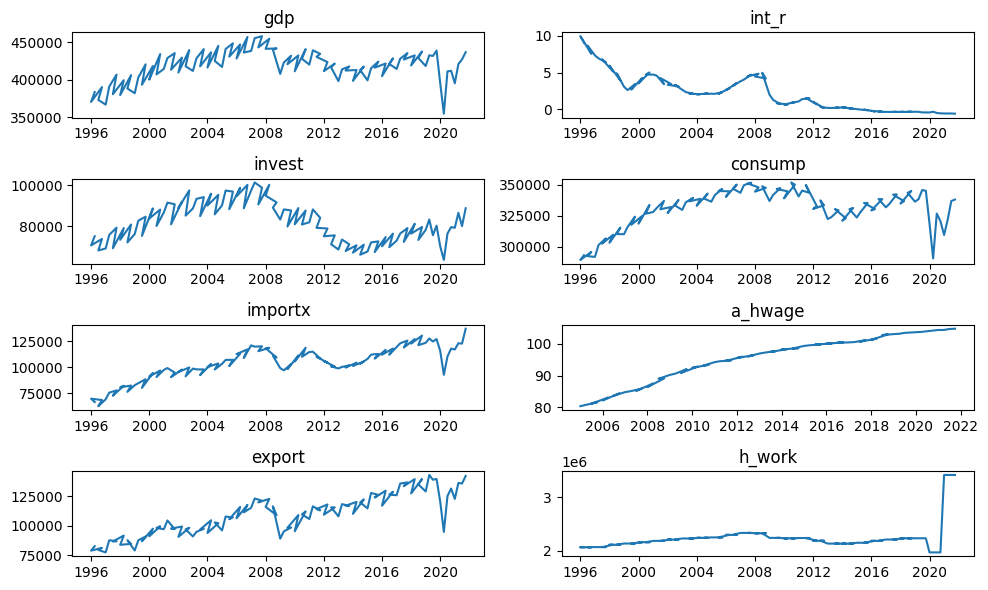

In [12]:
row = int(np.ceil(df.shape[1]/2))
fig, ax = plt.subplots(row, 2, figsize=(10, 1.5 * row))
for i,col in enumerate(df.columns):
    if i > row-1:
        c=1
        r=i-row
    else:
        c=0
        r=i
        
    ax[r, c].plot(df[col])
    ax[r, c].set_title(col)

fig.tight_layout()

In [14]:
# save data
df.to_csv(os.path.join(DATA_DIR, 'all_rbc_data.csv'))